# Actions as vector, and RL agent training

It is recommended to have a look at the [0_basic_functionalities](0_basic_functionalities.ipynb), [1_Observation_Agents](1_Observation_Agents.ipynb) and [2_Action_GridManipulation](2_Action_GridManipulation.ipynb) notebooks before getting into this one.

**Objectives**

In this notebook we will expose :
* how to use the "converters": some specific action_space that allows to manipulate a specific action representation
* how to train a (stupid) Agent using reinforcement learning.
* how to inspect (rapidly) the action taken by the Agent

**NB** for this tutorial we train an Agent inspired from this blog post: [deep-reinforcement-learning-tutorial-with-open-ai-gym](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368). Many other different reinforcement learning tutorial exist. The code showed in this notebook has no pretention except to demonstrate how to use Grid2Op functionality to train a Deep Reinforcement learning Agent and inspect its behaviour. There are absolutely nothing implied about the performance, training strategy, type of Agent, meta parameters etc. All of them are purely "random".


In [1]:
import os
import sys
import grid2op

In [2]:
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

Impossible to automatically add a menu / table of content to this notebook.
You can download "jyquickhelper" package with: 
"pip install jyquickhelper"


## I) Manipulating action representation

Grid2op package has been built with an "object oriented" perspective: almost everything is encapsulated in a dedicated `class`. This allows for more customization of the plateform.

The downside of this approach is that machine learning method, and especially deep learning, often prefers to deal with vectors rather than with `complex` objects. Indeed, as we covered in the previous tutorials on the platform, building our own actions can be tedious and can sometime require knowledge of the powergrid.

On the contrary, in most of standard Reinforcement Learning environment, actions have an higher representation. For example in pacman, there are 4 different types of actions: turn left, turn right, go up or do down. This allows for easy sampling (you need to achieve a uniform sampling you simply need to sample a number between 0 and 3 included) and an easy representation: each action is a different component of a vector of dimension 4 [because there are 4 actions]. 

On the other hand this representation is not "human friendly". It is quite convenient in the case of pacman because the action space is rather small making it possible to remember which action corresponds to which component, but in the case of the grid2op package, there are hundreds, sometimes thousands of actions, making it impossible to remember which component corresponds to which actions. We suppose we don't really care about this fact here, as tutorials on Reinforcement Learning with discrete action space often assume that actions are labelled with integer (such as in pacman for example).

Howerever, to allow the training of RL agent more easily, we allows to make some "[Converters](https://grid2op.readthedocs.io/en/latest/converters.html)" whose roles are to allow an agent to deal with a custom representation of the action space. The class [AgentWithConverter](https://grid2op.readthedocs.io/en/latest/agent.html#grid2op.Agent.AgentWithConverter) is perfect for such usage.

In [3]:
# import the usefull class
import numpy as np

from grid2op import make
from grid2op.Agent import RandomAgent 
max_iter = 100 # to make computation much faster we will only consider 50 time steps instead of 287

env = make(name_env="case14_redisp")
env.seed(0)  # this is to ensure the same action are taken by the "RandomAgent".
my_agent =  RandomAgent(env.action_space)

/home/benjamin/Documents/grid2op_test/getting_started/grid2op/MakeEnv.py:668: UserWarning:

Your are using only 2 chronics for this environment. More can be download by running, from a command line:
python -m grid2op.download --name "case14_redisp" --path_save PATH\WHERE\YOU\WANT\TO\DOWNLOAD\DATA



And that's it. This agent will be able to perform any action, but instead of going through the description of the actions from a powersystem point of view (ie setting what is connected to what, what is disconnected etc.) it will simply choose an integer with the method `my_act` this integer will then be converter back to a proper valid action.

Here we have an example on the action representation as seen by the Agent:

In [4]:
for el in range(3):
    print(my_agent.my_act(None, None))

172
47
117


And below you can see the "`act`" functions behaves as expected:

In [5]:
for el in range(3):
    print(my_agent.act(None, None))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (origin) 12 [on substation 5]
	 	 - assign bus 2 to line (origin) 13 [on substation 5]
	 	 - assign bus 1 to line (origin) 14 [on substation 5]
	 	 - assign bus 2 to line (extremity) 17 [on substation 5]
	 	 - assign bus 1 to generator 2 [on substation 5]
	 	 - assign bus 1 to load 5 [on substation 5]
This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of line (origin) 3 [on substation 8]
	 	 - switch bus of line (extremity) 16 [on substation 8]
	 	 - switch bus of line (extremity) 19 [on substation 8]
	 - NOT force any particular bus configuration
Th

**NB** lots of these actions are equivalent to the "do nothing" action at some point. For example, when trying to reconnect a powerline that is already connected will do nothing. Same for the topology. If everything is already connected to bus 1, then the action to connect things to bus 1 on the same substation will not affect the powergrid.

## II) Training an Agent

For this tutorial, we will expose to built a Q-learning Agent. Most of the code (except the neural network architecture) are inspired from this blog post: [https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368).

**Requirements** This notebook require to have `keras` installed on your machine.

As always in these notebook, we will use the `case14_fromfile` Environment. No proper care has been taken to set the thermal limits on this grid. It's unlikely that the agent can learn anything in this context.

### II.A) Defining some "helpers"

The type of Agent were are using require a bit of set up, independantly of Grid2Op. We will reuse the code showed in 
[https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368) and in [Reinforcement-Learning-Tutorial](https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial) from Abhinav Sagar code under a *MIT license* found here: [MIT License](https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial/blob/master/LICENSE).

This first section is here to define these classes.

But first let's import the necessary dependencies

In [6]:
#tf2.0 friendly
import numpy as np
import random
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import tensorflow.keras
    import tensorflow.keras.backend as K
    from tensorflow.keras.models import load_model, Sequential, Model
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, subtract, add
    from tensorflow.keras.layers import Input, Lambda, Concatenate

#### a) Replay buffer

 First we define a "replay buffer" necessary to train the Agent.

In [7]:
# Credit Abhinav Sagar: 
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial
# Code under MIT license, available at:
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial/blob/master/LICENSE
from collections import deque

class ReplayBuffer:
    """Constructs a buffer object that stores the past moves
    and samples a set of subsamples"""

    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()

    def add(self, s, a, r, d, s2):
        """Add an experience to the buffer"""
        # S represents current state, a is action,
        # r is reward, d is whether it is the end, 
        # and s2 is next state
        experience = (s, a, r, d, s2)
        if self.count < self.buffer_size:
            self.buffer.append(experience)
            self.count += 1
        else:    
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample(self, batch_size):
        """Samples a total of elements equal to batch_size from buffer
        if buffer contains enough elements. Otherwise return all elements"""

        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        # Maps each experience in batch in batches of states, actions, rewards
        # and new states
        s_batch, a_batch, r_batch, d_batch, s2_batch = list(map(np.array, list(zip(*batch))))

        return s_batch, a_batch, r_batch, d_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

#### b) Meta parameters of the methods

Then we re-use the default parameters, note that these can be optimized. Nothing has been changed for this example.

For more information about them, please refer to the blog post of Abhinav Sagar [available here](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368).

In [8]:
DECAY_RATE = 0.9
BUFFER_SIZE = 40000
MINIBATCH_SIZE = 64
TOT_FRAME = 3000000
EPSILON_DECAY = 10000
MIN_OBSERVATION = 42 #5000
FINAL_EPSILON = 1/300  # have on average 1 random action per scenario of approx 287 time steps
INITIAL_EPSILON = 0.1
TAU = 0.01
ALPHA = 1
# Number of frames to "throw" into network
NUM_FRAMES = 1 ## this has been changed compared to the original implementation.

### II.B) Adapatation of the inputs

In the original code, the models were used to play an Atari game and the inputs were images. For our system, the inputs are "Observation" converted as vector.

For a more detailed description of the code used, please check:
* [https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368)
* and [Reinforcement-Learning-Tutorial](https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial)


This is why we adapted the original code from Abhinav Sagar:
* We replaced convolutional layers with fully connected (dense) layers
* We made sure not to look at all the observations, but rather at only some part of it.

#### a) extracting relevant information of observation

First we extract relevant information about the dimension of the observation space, and the action space.

In [9]:
OBSERVATION_SIZE = env.observation_space.size()
NUM_ACTIONS = my_agent.action_space.n

A few comments here.

First, we don't change anything to the observation space. This means that the vector the agent will receive is really big, not scaled and with lots of informations that are not really usefull.

#### b) Code the neural networks

The code of the neural networks, used to solve this problem is modified very slightly to adapt. The biggest changes come from removing the convolutional layers, as well as adapting the input and output size.

For each of the method below, we specify what have been adapted/modified in comparison with the original blog post by Abhinav.

We want to emphasize here that these models are used through the "`predict_movement`" method. This method outputs an integer: the action id that maximizes the expected reward at the current tim step in an episode of the game during the training process. It's perfectly suited to use a representation of actions with integer rather than with complete descriptions of what the agent is doing.

### II.C) Making the code of the Agent and train it

In the "reference" article [https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368](https://towardsdatascience.com/deep-reinforcement-learning-tutorial-with-open-ai-gym-c0de4471f368), the author Abhinav Sagar made a dedicated environment based on SpaceInvader in the gym repository. We proceed here on a similar way, but with a the grid2op environment.

#### a) Adapated code

In [10]:
# Credit Abhinav Sagar: 
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial
# Code under MIT license, available at:
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial/blob/master/LICENSE

class DeepQ(object):
    """Constructs the desired deep q learning network"""
    def __init__(self, action_size, lr=1e-5, observation_size=OBSERVATION_SIZE):
        # It is not modified from  Abhinav Sagar's code, except for adding the possibility to change the learning rate
        # in parameter is also present the size of the action space
        # (it used to be a global variable in the original code)
        self.action_size = action_size
        self.observation_size = observation_size
        self.model = None
        self.target_model = None
        self.lr_ = lr
        self.qvalue_evolution = []
        self.construct_q_network()
    
    def construct_q_network(self):
        # replacement of the Convolution layers by Dense layers, and change the size of the input space and output space
        
        # Uses the network architecture found in DeepMind paper
        self.model = Sequential()
        input_layer = Input(shape = (self.observation_size*NUM_FRAMES,))
        layer1 = Dense(self.observation_size*NUM_FRAMES)(input_layer)
        layer1 = Activation('relu')(layer1)
        layer2 = Dense(self.observation_size)(layer1)
        layer2 = Activation('relu')(layer2)
        layer3 = Dense(self.observation_size)(layer2)
        layer3 = Activation('relu')(layer3)
        layer4 = Dense(2*NUM_ACTIONS)(layer3)
        layer4 = Activation('relu')(layer4)
        output = Dense(NUM_ACTIONS)(layer4)
        
        self.model = Model(inputs=[input_layer], outputs=[output])
        self.model.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        self.target_model = Model(inputs=[input_layer], outputs=[output])
        self.target_model.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        self.target_model.set_weights(self.model.get_weights())
    
    def predict_movement(self, data, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        # nothing has changed from the original implementation
        rand_val = np.random.random()
        q_actions = self.model.predict(data.reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
        
        if rand_val < epsilon:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
        else:
            opt_policy = np.argmax(np.abs(q_actions))
            
        self.qvalue_evolution.append(q_actions[0,opt_policy])

        return opt_policy, q_actions[0, opt_policy]

    def train(self, s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num):
        """Trains network to fit given parameters"""
        # nothing has changed from the original implementation, except for changing the input dimension 'reshape'
        batch_size = s_batch.shape[0]
        targets = np.zeros((batch_size, NUM_ACTIONS))

        for i in range(batch_size):
            targets[i] = self.model.predict(s_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            fut_action = self.target_model.predict(s2_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            targets[i, a_batch[i]] = r_batch[i]
            if d_batch[i] == False:
                targets[i, a_batch[i]] += DECAY_RATE * np.max(fut_action)
        loss = self.model.train_on_batch(s_batch, targets)
        # Print the loss every 100 iterations.
        if observation_num % 100 == 0:
            print("We had a loss equal to ", loss)

    def save_network(self, path):
        # Saves model at specified path as h5 file
        # nothing has changed
        self.model.save(path)
        print("Successfully saved network.")

    def load_network(self, path):
        # nothing has changed
        self.model = load_model(path)
        print("Succesfully loaded network.")

    def target_train(self):
        # nothing has changed from the original implementation
        model_weights = self.model.get_weights()
        target_model_weights = self.target_model.get_weights()
        for i in range(len(model_weights)):
            target_model_weights[i] = TAU * model_weights[i] + (1 - TAU) * target_model_weights[i]
        self.target_model.set_weights(target_model_weights)
        
class DuelQ(object):
    """Constructs the desired deep q learning network"""
    def __init__(self, action_size, lr=0.00001, observation_size=OBSERVATION_SIZE):
        # It is not modified from  Abhinav Sagar's code, except for adding the possibility to change the learning rate
        # in parameter is also present the size of the action space
        # (it used to be a global variable in the original code)
        self.action_size = action_size
        self.observation_size = observation_size
        self.lr_ = lr
        self.model = None
        self.qvalue_evolution = []
        self.construct_q_network()

    def construct_q_network(self):
        # Uses the network architecture found in DeepMind paper
        # The inputs and outputs size have changed, as well as replacing the convolution by dense layers.
        self.model = Sequential()
        
        input_layer = Input(shape = (self.observation_size*NUM_FRAMES,))
        lay1 = Dense(self.observation_size*NUM_FRAMES)(input_layer)
        lay1 = Activation('relu')(lay1)
        
        lay2 = Dense(self.observation_size)(lay1)
        lay2 = Activation('relu')(lay2)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay2)
        lay3 = Activation('relu')(lay3)
        
        fc1 = Dense(NUM_ACTIONS)(lay3)
        advantage = Dense(NUM_ACTIONS)(fc1)
        fc2 = Dense(NUM_ACTIONS)(lay3)
        value = Dense(1)(fc2)
        
        meaner = Lambda(lambda x: K.mean(x, axis=1) )
        mn_ = meaner(advantage)  
        tmp = subtract([advantage, mn_])  # keras doesn't like this part...
        policy = add([tmp, value])

        self.model = Model(inputs=[input_layer], outputs=[policy])
        self.model.compile(loss='mse', optimizer=Adam(lr=self.lr_))

        self.target_model = Model(inputs=[input_layer], outputs=[policy])
        self.target_model.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        print("Successfully constructed networks.")
    
    def predict_movement(self, data, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        # only changes lie in adapting the input shape
        q_actions = self.model.predict(data.reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
        opt_policy = np.argmax(q_actions)
        rand_val = np.random.random()
        if rand_val < epsilon:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
            
        self.qvalue_evolution.append(q_actions[0,opt_policy])

        return opt_policy, q_actions[0, opt_policy]

    def train(self, s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num):
        """Trains network to fit given parameters"""
        # nothing has changed except adapting the input shapes
        batch_size = s_batch.shape[0]
        targets = np.zeros((batch_size, NUM_ACTIONS))

        for i in range(batch_size):
            targets[i] = self.model.predict(s_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            fut_action = self.target_model.predict(s2_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            targets[i, a_batch[i]] = r_batch[i]
            if d_batch[i] == False:
                targets[i, a_batch[i]] += DECAY_RATE * np.max(fut_action)

        loss = self.model.train_on_batch(s_batch, targets)

        # Print the loss every 100 iterations.
        if observation_num % 100 == 0:
            print("We had a loss equal to ", loss)

    def save_network(self, path):
        # Saves model at specified path as h5 file
        # nothing has changed
        self.model.save(path)
        print("Successfully saved network.")

    def load_network(self, path):
        # nothing has changed
        self.model.load_weights(path)
        self.target_model.load_weights(path)
        print("Succesfully loaded network.")

    def target_train(self):
        # nothing has changed
        model_weights = self.model.get_weights()
        self.target_model.set_weights(model_weights)

Another custom made version of the Q-Learning algorithm

In [11]:
class RealQ(object):
    """Constructs the desired deep q learning network"""
    def __init__(self, action_size, lr=1e-5, observation_size=OBSERVATION_SIZE, mean_reg=False):

        self.action_size = action_size
        self.observation_size = observation_size
        self.model = None
        self.target_model = None
        self.lr_ = lr
        self.mean_reg = mean_reg
        
        self.qvalue_evolution=[]

        self.construct_q_network()
        
    def construct_q_network(self):

        self.model = Sequential()
        
        input_states = Input(shape = (self.observation_size,))
        input_action = Input(shape = (NUM_ACTIONS,))
        input_layer = Concatenate()([input_states, input_action])
        
        lay1 = Dense(self.observation_size)(input_layer)
        lay1 = Activation('relu')(lay1)
        
        lay2 = Dense(self.observation_size)(lay1)
        lay2 = Activation('relu')(lay2)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay2)
        lay3 = Activation('relu')(lay3)
        
        fc1 = Dense(NUM_ACTIONS)(lay3)
        advantage = Dense(1, activation = 'linear')(fc1)
        
        if self.mean_reg==True:
            advantage = Lambda(lambda x : x - K.mean(x))(advantage)
        
        self.model = Model(inputs=[input_states, input_action], outputs=[advantage])
        self.model.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        
        self.model_copy = Model(inputs=[input_states, input_action], outputs=[advantage])
        self.model_copy.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        self.model_copy.set_weights(self.model.get_weights())
        
    def predict_movement(self, states, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        # nothing has changed from the original implementation
        rand_val = np.random.random()
        q_actions = self.model.predict([np.tile(states.reshape(1, self.observation_size),(NUM_ACTIONS,1)), np.eye(NUM_ACTIONS)]).reshape(1,-1)
        if rand_val < epsilon:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
        else:
            opt_policy = np.argmax(np.abs(q_actions))
            
        self.qvalue_evolution.append(q_actions[0,opt_policy])
        
        return opt_policy, q_actions[0,opt_policy]

    def train(self, s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num):
        """Trains network to fit given parameters"""
        # nothing has changed from the original implementation, except for changing the input dimension 'reshape'
        batch_size = s_batch.shape[0]
        targets = np.zeros(batch_size)
        last_action=np.zeros((batch_size, NUM_ACTIONS))
        for i in range(batch_size):
            last_action[i,a_batch[i]] = 1
            q_pre = self.model.predict([s_batch[i].reshape(1, self.observation_size), last_action[i].reshape(1,-1)], batch_size=1).reshape(1,-1)
            q_fut = self.model_copy.predict([np.tile(s2_batch[i].reshape(1, self.observation_size),(NUM_ACTIONS,1)), np.eye(NUM_ACTIONS)]).reshape(1,-1)
            fut_action = np.max(q_fut)
            if d_batch[i] == False:
                targets[i] = ALPHA * (r_batch[i] + DECAY_RATE * fut_action - q_pre)
            else:
                targets[i] = ALPHA * (r_batch[i] - q_pre)
        loss = self.model.train_on_batch([s_batch, last_action], targets)
        # Print the loss every 100 iterations.
        if observation_num % 100 == 0:
            print("We had a loss equal to ", loss)

    def save_network(self, path):
        # Saves model at specified path as h5 file
        # nothing has changed
        self.model.save(path)
        print("Successfully saved network.")

    def load_network(self, path):
        # nothing has changed
        self.model = load_model(path)
        print("Succesfully loaded network.")

    def target_train(self):
        # nothing has changed from the original implementation
        model_weights = self.model.get_weights() 
        target_model_weights = self.model_copy.get_weights()
        for i in range(len(model_weights)):
            target_model_weights[i] = TAU * model_weights[i] + (1 - TAU) * target_model_weights[i]
        self.model_copy.set_weights(model_weights)
        

A version of SAC algorithm as described in https://spinningup.openai.com/en/latest/algorithms/sac.html

In [12]:
class SAC(object):
    """Constructs the desired deep q learning network"""
    def __init__(self, action_size, lr=1e-5, observation_size=OBSERVATION_SIZE):

        self.action_size = action_size
        self.observation_size = observation_size
        self.model = None
        self.target_model = None
        self.lr_ = lr
        self.average_reward = 0
        self.life_spent = 1
        self.qvalue_evolution = []
        self.Is_nan = False

        self.construct_q_network()
        
    def build_q_NN(self):
        model = Sequential()
        
        input_states = Input(shape = (self.observation_size,))
        input_action = Input(shape = (NUM_ACTIONS,))
        input_layer = Concatenate()([input_states, input_action])
        
        lay1 = Dense(self.observation_size)(input_layer)
        lay1 = Activation('relu')(lay1)
        
        lay2 = Dense(self.observation_size)(lay1)
        lay2 = Activation('relu')(lay2)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay2)
        lay3 = Activation('relu')(lay3)
        
        advantage = Dense(1, activation = 'linear')(lay3)
        
        model = Model(inputs=[input_states, input_action], outputs=[advantage])
        model.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        
        return model
    
    def construct_q_network(self):
        #construct double Q networks
        self.model_Q = self.build_q_NN()
        self.model_Q2 = self.build_q_NN()

    
        #state value function approximation
        self.model_value = Sequential()
        
        input_states = Input(shape = (self.observation_size,))
        
        lay1 = Dense(self.observation_size)(input_states)
        lay1 = Activation('relu')(lay1)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay1)
        lay3 = Activation('relu')(lay3)
        
        advantage = Dense(NUM_ACTIONS, activation = 'relu')(lay3)
        state_value = Dense(1, activation = 'linear')(advantage)
        
        self.model_value = Model(inputs=[input_states], outputs=[state_value])
        self.model_value.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        
        self.model_value_target = Sequential()
        
        input_states = Input(shape = (self.observation_size,))
        
        lay1 = Dense(self.observation_size)(input_states)
        lay1 = Activation('relu')(lay1)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay1)
        lay3 = Activation('relu')(lay3)
        
        advantage = Dense(NUM_ACTIONS, activation = 'relu')(lay3)
        state_value = Dense(1, activation = 'linear')(advantage)
        
        self.model_value_target = Model(inputs=[input_states], outputs=[state_value])
        self.model_value_target.compile(loss='mse', optimizer=Adam(lr=self.lr_))
        self.model_value_target.set_weights(self.model_value.get_weights())
        #policy function approximation
        
        self.model_policy = Sequential()
        input_states = Input(shape = (self.observation_size,))
        lay1 = Dense(self.observation_size)(input_states)
        lay1 = Activation('relu')(lay1)
        
        lay2 = Dense(self.observation_size)(lay1)
        lay2 = Activation('relu')(lay2)
        
        lay3 = Dense(2*NUM_ACTIONS)(lay2)
        lay3 = Activation('relu')(lay3)
        
        soft_proba = Dense(NUM_ACTIONS, activation="softmax", kernel_initializer='uniform')(lay3)
        
        self.model_policy = Model(inputs=[input_states], outputs=[soft_proba])
        self.model_policy.compile(loss='categorical_crossentropy', optimizer=Adam(lr=self.lr_))
        
        print("Successfully constructed networks.")
        
    def predict_movement(self, states, epsilon):
        """Predict movement of game controler where is epsilon
        probability randomly move."""
        # nothing has changed from the original implementation
        p_actions = self.model_policy.predict(states.reshape(1, self.observation_size)).ravel()
        rand_val = np.random.random()
        
        if rand_val < epsilon / 10:
            opt_policy = np.random.randint(0, NUM_ACTIONS)
        else:
            #opt_policy = np.random.choice(np.arange(NUM_ACTIONS, dtype=int), size=1, p = p_actions)
            opt_policy = np.argmax(p_actions)
                            
        return np.int(opt_policy), p_actions[opt_policy]

    def train(self, s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num):
        """Trains networks to fit given parameters"""

        # nothing has changed from the original implementation, except for changing the input dimension 'reshape'
        batch_size = s_batch.shape[0]
        target = np.zeros((batch_size, 1))
        new_proba = np.zeros((batch_size, NUM_ACTIONS))
        last_action=np.zeros((batch_size, NUM_ACTIONS))
        
        #training of the action state value networks
        last_action=np.zeros((batch_size, NUM_ACTIONS))

        for i in range(batch_size):
            last_action[i,a_batch[i]] = 1

            v_t = self.model_value_target.predict(s_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            
            self.qvalue_evolution.append(v_t[0])
            fut_action = self.model_value_target.predict(s2_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)

            target[i,0] = r_batch[i] + (1 - d_batch[i]) * DECAY_RATE * fut_action   

                
        loss = self.model_Q.train_on_batch([s_batch, last_action], target)
        loss_2 = self.model_Q2.train_on_batch([s_batch, last_action], target) 
            
        #training of the policy
        
        for i in range(batch_size):
            self.life_spent += 1
            temp =  1 / np.log(self.life_spent) / 2
            new_values = self.model_Q.predict([np.tile(s_batch[i].reshape(1, self.observation_size),(NUM_ACTIONS,1)),
                                                      np.eye(NUM_ACTIONS)]).reshape(1,-1)
            new_values -= np.amax(new_values, axis=-1)
            new_proba[i] = np.exp(new_values / temp) / np.sum(np.exp(new_values / temp), axis=-1)
            
        loss_policy = self.model_policy.train_on_batch(s_batch, new_proba)
    
        #training of the value_function
        value_target = np.zeros(batch_size)
        for i in range(batch_size):
            target_pi = self.model_policy.predict(s_batch[i].reshape(1, self.observation_size*NUM_FRAMES), batch_size = 1)
            action_v1 = self.model_Q.predict([np.tile(s_batch[i].reshape(1, self.observation_size),(NUM_ACTIONS,1)),
                                                      np.eye(NUM_ACTIONS)]).reshape(1,-1)
            action_v2 = self.model_Q2.predict([np.tile(s_batch[i].reshape(1, self.observation_size),(NUM_ACTIONS,1)),
                                                      np.eye(NUM_ACTIONS)]).reshape(1,-1)
            value_target[i] = np.fmin(action_v1[0,a_batch[i]], action_v2[0,a_batch[i]]) - np.sum(target_pi * np.log(target_pi + 1e-6))
        
        loss_value = self.model_value.train_on_batch(s_batch, value_target.reshape(-1,1))
        
        self.Is_nan = np.isnan(loss) + np.isnan(loss_2) + np.isnan(loss_policy) + np.isnan(loss_value)
        # Print the loss every 100 iterations.
        if observation_num % 100 == 0:
            print("We had a loss equal to ", loss, loss_2, loss_policy, loss_value)

    def save_network(self, path):
        # Saves model at specified path as h5 file
        # nothing has changed
        self.model_policy.save("policy_"+path)
        self.model_value_target.save("value_"+path)
        print("Successfully saved network.")

    def load_network(self, path):
        # nothing has changed
        self.model_policy = load_model("policy_"+path)
        elf.model_value_target = load_model("value_"+path)
        print("Succesfully loaded network.")

    def target_train(self):
        # nothing has changed from the original implementation
        model_weights = self.model_value.get_weights() 
        target_model_weights = self.model_value_target.get_weights()
        for i in range(len(model_weights)):
            target_model_weights[i] = TAU * model_weights[i] + (1 - TAU) * target_model_weights[i]
        self.model_value_target.set_weights(model_weights)
        

We first show how the agent code looks like without the "utilities" to train it. As we can see, defining this agent is pretty simple. The only real method that need to be adapted it "`my_act`" that is a method of 2 lines of code.

In [13]:
# Credit Abhinav Sagar: 
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial
# Code under MIT license, available at:
# https://github.com/abhinavsagar/Reinforcement-Learning-Tutorial/blob/master/LICENSE

from grid2op.Parameters import Parameters
from grid2op.Agent import AgentWithConverter
from grid2op.Converter import IdToAct
import pdb


class DeepQAgent(AgentWithConverter):
    # first change: An Agent must derived from grid2op.Agent (in this case MLAgent, because we manipulate vector instead
    # of classes)
    
    def convert_obs(self, observation):
        return observation.to_vect()
        
    def my_act(self, transformed_observation, reward, done=False):
        if self.deep_q is None:
            self.init_deep_q(transformed_observation)
        predict_movement_int, *_ = self.deep_q.predict_movement(transformed_observation, epsilon=0.0)
        # print("predict_movement_int: {}".format(predict_movement_int))
        return predict_movement_int
    
    def init_deep_q(self, transformed_observation):
        if self.deep_q is None:
            # the first time an observation is observed, I set up the neural network with the proper dimensions.
            if self.mode == "DQN":
                cls = DeepQ
            elif self.mode == "DDQN":
                cls = DuelQ
            elif self.mode == "RealQ":
                cls = RealQ
            elif self.mode == "SAC":
                cls = SAC
            else:
                raise RuntimeError("Unknown neural network named \"{}\"".format(self.mode))
            self.deep_q = cls(self.action_space.size(), observation_size=transformed_observation.shape[0], lr=self.lr)
            
    def __init__(self, action_space, mode="DDQN", lr=1e-5):
        # this function has been adapted.
        
        # to built a AgentWithConverter, we need an action_space. 
        # No problem, we add it in the constructor.
        AgentWithConverter.__init__(self, action_space, action_space_converter=IdToAct)
        
        # and now back to the origin implementation
        self.replay_buffer = ReplayBuffer(BUFFER_SIZE)
        
        # compare to original implementation, i don't know the observation space size. 
        # Because it depends on the component of the observation we want to look at. So these neural network will
        # be initialized the first time an observation is observe.
        self.deep_q = None
        self.mode = mode
        self.lr=lr
    
    def load_network(self, path):
        # not modified compare to original implementation
        self.deep_q.load_network(path)
    
    def convert_process_buffer(self):
        """Converts the list of NUM_FRAMES images in the process buffer
        into one training sample"""
        # here i simply concatenate the action in case of multiple action in the "buffer"
        # this function existed in the original implementation, bus has been adapted.
        return np.concatenate(self.process_buffer)

And now we will also define some utility class (as defined in the blog post) to make the training easier.

In [14]:
from grid2op.Reward import L2RPNReward
from grid2op.Reward import RedispReward

class L2RPNReward_LoadWise(L2RPNReward):
    """
    Update the L2RPN reward to take into account the fact that a change in the loads sum shall not be allocated as reward for the agent.
    
    """
    def __init__(self):
        super().__init__()
    
    def initialize(self, env):
        super().initialize(env)
        self.reward_min = - 10 * env.backend.n_line
        self.previous_loads = self.reward_max * np.ones(env.backend.n_line)
        
    def __call__(self, action, env, has_error, is_done, is_illegal, is_ambiguous):
        if not is_done and not has_error:
            line_cap = self._L2RPNReward__get_lines_capacity_usage(env)
            
            new_loads, _, _ = env.backend.loads_info()
            new_flows = np.abs(env.backend.get_line_flow())
            loads_variation = (np.sum(new_loads) - np.sum(self.previous_loads)) / np.sum(self.previous_loads)
            
            res = np.sum(line_cap  + loads_variation)
        else:
            # no more data to consider, no powerflow has been run, reward is what it is
            res = self.reward_min
        return res
      
class L2RPNReward_LoadWise_ActionWise(L2RPNReward):
    """
    Update the L2RPN reward to take into account the fact that a change in the loads sum shall not be allocated as reward for the agent.
    
    """
    def __init__(self):
        super().__init__()
        
    def initialize(self, env):
        super().initialize(env)
        self.reward_min = - 10 * env.backend.n_line
        self.previous_loads = self.reward_max * np.ones(env.backend.n_line)
        self.last_action = env.helper_action_env({})
        
    def __call__(self, action, env, has_error, is_done, is_illegal, is_ambiguous):
        if not is_done and not has_error:
            line_cap = self._L2RPNReward__get_lines_capacity_usage(env)
            
            new_loads, _, _ = env.backend.loads_info()
            new_flows = np.abs(env.backend.get_line_flow())
            loads_variation = (np.sum(new_loads) - np.sum(self.previous_loads)) / np.sum(self.previous_loads)
            
            res = np.sum(line_cap  + loads_variation)
        else:
            # no more data to consider, no powerflow has been run, reward is what it is
            res = self.reward_min
            
        res -= (action != env.helper_action_env({})) * (action == self.last_action) * env.backend.n_line / 2
            
        self.last_action = action
        
        return res
      


In [15]:
class TrainAgent(object):
    def __init__(self, agent, reward_fun=RedispReward, env=None):
        self.agent = agent
        self.reward_fun = reward_fun
        self.env = env
        
    def _build_valid_env(self):
        # now we are creating a valid Environment
        # it's mandatory because no environment are created when the agent is 
        # an Agent should not get direct access to the environment, but can interact with it only by:
        # * receiving reward
        # * receiving observation
        # * sending action
        
        close_env = False
        
        if self.env is None:
            self.env = grid2op.make(action_class=type(self.agent.action_space({})),
                                    reward_class=self.reward_fun)
            close_env = True
                               
        # I make sure the action space of the user and the environment are the same.
        if not isinstance(self.agent.init_action_space, type(self.env.action_space)):
            raise RuntimeError("Imposssible to build an agent with 2 different action space")
        if not isinstance(self.env.action_space, type(self.agent.init_action_space)):
            raise RuntimeError("Imposssible to build an agent with 2 different action space")
        
        # A buffer that keeps the last `NUM_FRAMES` images
        self.agent.replay_buffer.clear()
        self.agent.process_buffer = []
        
        # make sure the environment is reset
        obs = self.env.reset()
        self.agent.process_buffer.append(self.agent.convert_obs(obs))
        do_nothing = self.env.action_space()
        for _ in range(NUM_FRAMES-1):
            # Initialize buffer with the first frames
            s1, r1, _, _ = self.env.step(do_nothing)
            self.agent.process_buffer.append(self.agent.convert_obs(s1))            
        return close_env
    
    def train(self, num_frames, env=None):
        # this function existed in the original implementation, but has been slightly adapted.
        
        # first we create an environment or make sure the given environment is valid
        close_env = self._build_valid_env()
        
        # bellow that, only slight modification has been made. They are highlighted
        observation_num = 0
        curr_state = self.agent.convert_process_buffer()
        epsilon = INITIAL_EPSILON
        alive_frame = 0
        total_reward = 0

        while observation_num < num_frames:
            if observation_num % 1000 == 999:
                print(("Executing loop %d" %observation_num))

            # Slowly decay the learning rate
            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON-FINAL_EPSILON)/EPSILON_DECAY

            initial_state = self.agent.convert_process_buffer()
            self.agent.process_buffer = []

            # it's a bit less convenient that using the SpaceInvader environment.
            # first we need to initiliaze the neural network
            self.agent.init_deep_q(curr_state)
            # then we need to predict the next move
            predict_movement_int, predict_q_value = self.agent.deep_q.predict_movement(curr_state, epsilon)
            # and then we convert it to a valid action
            act = self.agent.convert_act(predict_movement_int)
            
            reward, done = 0, False
            for i in range(NUM_FRAMES):
                temp_observation_obj, temp_reward, temp_done, _ = self.env.step(act)
                # here it has been adapted too. The observation get from the environment is
                # first converted to vector
                
                # below this line no changed have been made to the original implementation.
                reward += temp_reward
                self.agent.process_buffer.append(self.agent.convert_obs(temp_observation_obj))
                done = done | temp_done

            if done:
                print("Lived with maximum time ", alive_frame)
                print("Earned a total of reward equal to ", total_reward)
                # reset the environment
                self.env.reset()
                
                alive_frame = 0
                total_reward = 0

            new_state = self.agent.convert_process_buffer()
            self.agent.replay_buffer.add(initial_state, predict_movement_int, reward, done, new_state)
            total_reward += reward
            if self.agent.replay_buffer.size() > MIN_OBSERVATION:
                s_batch, a_batch, r_batch, d_batch, s2_batch = self.agent.replay_buffer.sample(MINIBATCH_SIZE)
                self.agent.deep_q.train(s_batch, a_batch, r_batch, d_batch, s2_batch, observation_num)
                self.agent.deep_q.target_train()

            # Save the network every 1000 iterations after 50000 iterations
            if observation_num > 50000 and observation_num % 1000 == 0 and self.agent.deep_q.Is_nan == 0:
                print("Saving Network")
                self.agent.deep_q.save_network("saved_agent_"+self.agent.mode+".h5")

            alive_frame += 1
            observation_num += 1
            
        if close_env:
            print("closing env")
            self.env.close()
            
    def calculate_mean(self, num_episode = 100, env=None):
        # this method has been only slightly adapted from the original implementation
        
        # Note that it is NOT the recommended method to evaluate an Agent. Please use "Grid2Op.Runner" instead
        
        # first we create an environment or make sure the given environment is valid
        close_env = self._build_valid_env()
        
        reward_list = []
        print("Printing scores of each trial")
        for i in range(num_episode):
            done = False
            tot_award = 0
            self.env.reset()
            while not done:
                state = self.convert_process_buffer()
                
                # same adapation as in "train" function. 
                predict_movement_int = self.agent.deep_q.predict_movement(state, 0.0)[0]
                predict_movement = self.agent.convert_act(predict_movement_int)
                
                # same adapation as in the "train" funciton
                observation_obj, reward, done, _ = self.env.step(predict_movement)
                observation_vect_full = observation_obj.to_vect()
                
                tot_award += reward
                self.process_buffer.append(observation)
                self.process_buffer = self.process_buffer[1:]
            print(tot_award)
            reward_list.append(tot_award)
            
        if close_env:
            self.env.close()
        return np.mean(reward_list), np.std(reward_list)

#### b) Training the model

Now we can define the model (agent), and then train it.

This is done exactly the same way as in the Abhinav Sagar implementation.

**NB** The code bellow can take a few minutes to run. It's training a Deep Reinforcement Learning Agent afterall. It this takes too long on your machine, you can always decrease the "nb_frame", and set it to 1000 for example. In this case, the Agent will probably not be really good.

**NB** For a real Agent, it would take much longer to train.

In [16]:
nb_frame = 100

env = make(name_env="case14_redisp")
my_agent = DeepQAgent(env.action_space, mode="DDQN")
trainer = TrainAgent(agent=my_agent, env=env, reward_fun=RedispReward)
trainer.train(nb_frame)
trainer.agent.deep_q.save_network("saved_agent_"+trainer.agent.mode+".h5")

/home/benjamin/Documents/grid2op_test/getting_started/grid2op/MakeEnv.py:668: UserWarning:

Your are using only 2 chronics for this environment. More can be download by running, from a command line:
python -m grid2op.download --name "case14_redisp" --path_save PATH\WHERE\YOU\WANT\TO\DOWNLOAD\DATA



Successfully constructed networks.
Lived with maximum time  87
Earned a total of reward equal to  99318.90852576918
Lived with maximum time  8
Earned a total of reward equal to  7582.116955233524
Successfully saved network.


# To see whether the agent learnt something during training: lets plot the learning curve

(0.0, 100.0)

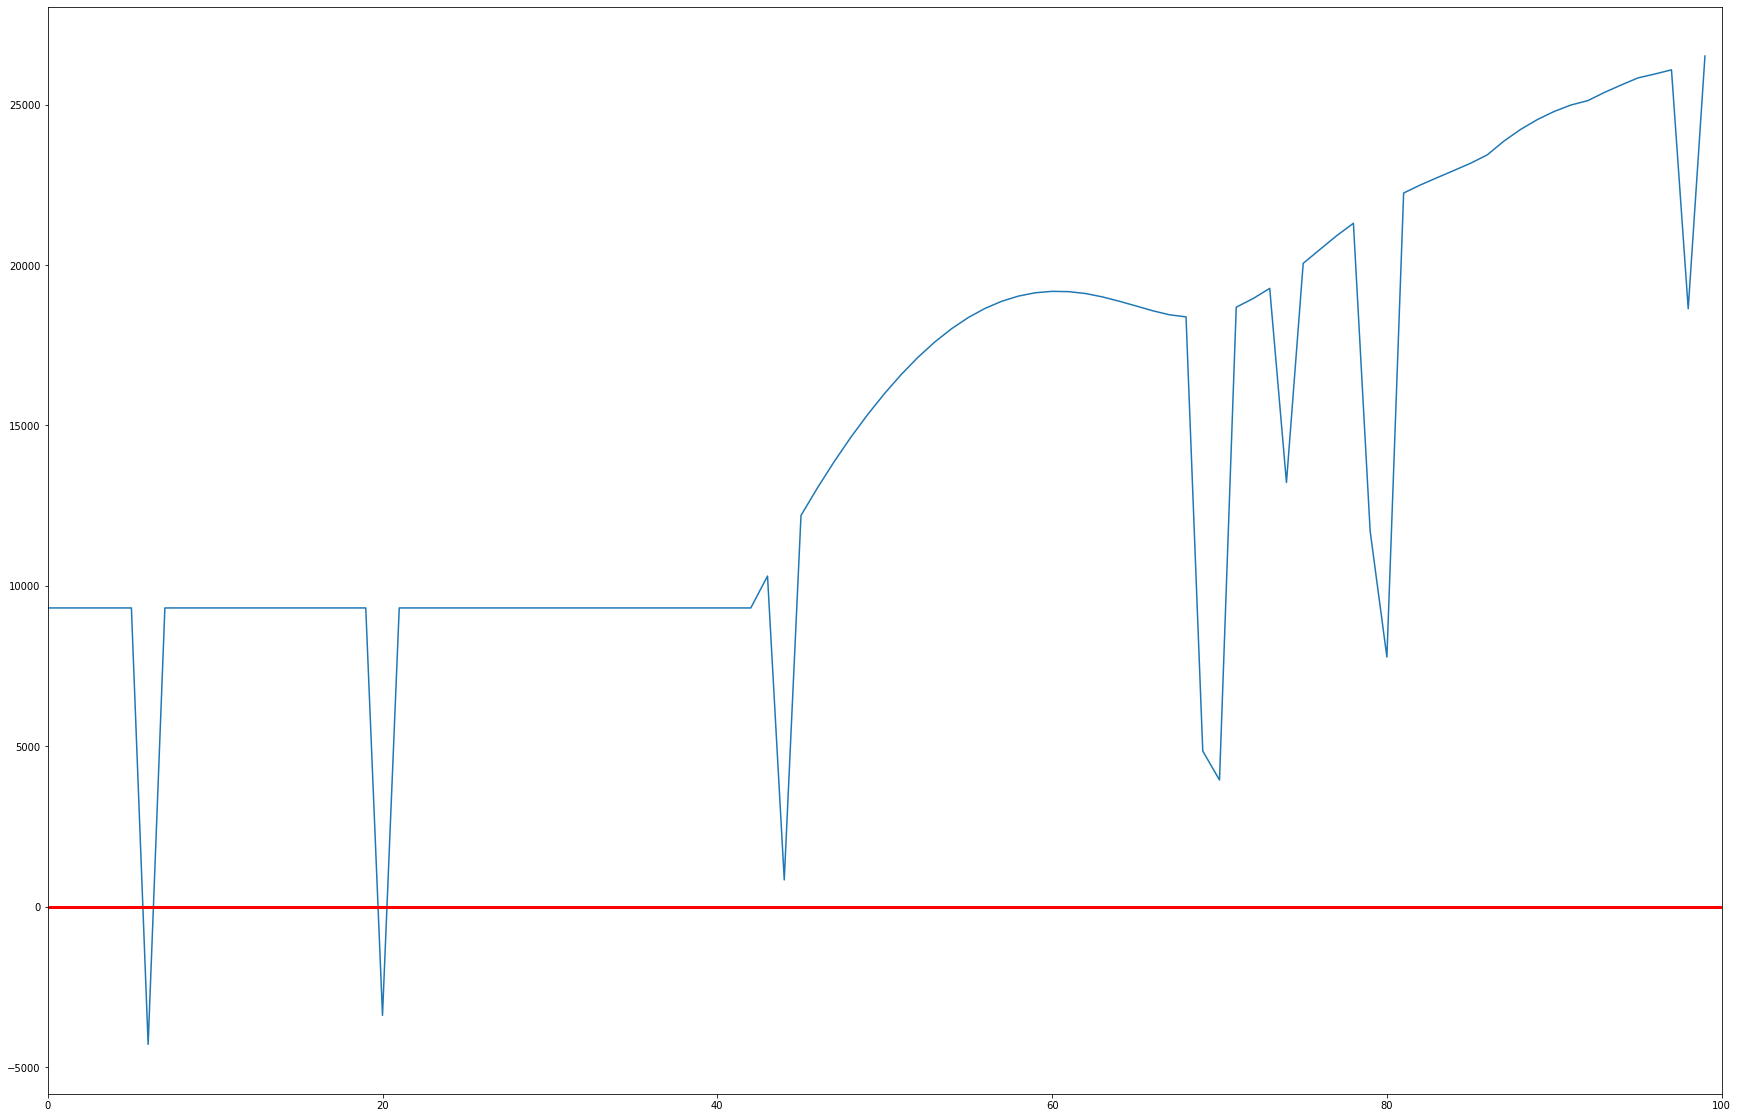

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))

The learning curve shown above is really poor. It's because the agent has not been trained for a long time (and because it uses a very poor input data). If you train this agent for approximately 10-12 hours, using only the relative flow (`obs.rho` see the last section of this notebook for an example) you will get the following:

![](img/trained_agent.png)

## III) Evaluating the Agent

And now, time to test this trained agent.

To do that, we have multiple choices.

Either we recode the "DeepQAgent" class to load the stored weights (that have been saved during trainig) when it is initialized (not covered in this notebook), or we can also directly specify the "instance" of the Agent to use in the Grid2Op Runner.

To do that, it's fairly simple. First, you need to specify that you won't use the "*agentClass*" argument, by setting it to ``None``, and secondly you simply provide the agent to use in the *agentInstance* argument.

**NB** If you don't do that, the Runner will be created (the constructor will raise an exception). And if you choose to use the "*agentClass*" argument, your agent will be reloaded from scratch. So **if it doesn't load the weights** it will behave as a non trained agent, unlikely to perform well on the task.

### III.A) Evaluate the Agent

Now that we have "successfully" trained our Agent, we will evaluating it. As opposed to the trainining, the evaluation is done classically using a standard Runner.

Note that the Runner will use a "scoring function" that might be different from the "reward function" used during training. In our case, it's not. We use the `L2RPNReward` in both cases.

In the code bellow, we commented on what can be different and what must be identical for training and evaluation of model.

In [18]:
from grid2op.Runner import Runner
from grid2op.Chronics import GridStateFromFileWithForecasts, Multifolder
scoring_function = L2RPNReward

dict_params = env.get_params_for_runner()
dict_params["gridStateclass_kwargs"]["max_iter"] =  max_iter
# make a runner from an intialized environment
runner = Runner(**dict_params)

Run the Agent and save the results. As opposed to the multiple times we exposed the "runner.run" call, we never really dive into the "path_save" argument. This path allows you to save lots of information about your Agent behaviour. Please All the informations present are shown on the documentation [here](https://grid2op.readthedocs.io/en/latest/runner.html).

In [19]:
import shutil
path_save="trained_agent_log"

# delete the previous stored results
if os.path.exists(path_save):
    shutil.rmtree(path_save)

# run the episode
res = runner.run(nb_episode=1, path_save=path_save)
print("The results for the trained agent are:")
for _, chron_name, cum_reward, nb_time_step, max_ts in res:
    msg_tmp = "\tFor chronics located at {}\n".format(chron_name)
    msg_tmp += "\t\t - cumulative reward: {:.6f}\n".format(cum_reward)
    msg_tmp += "\t\t - number of time steps completed: {:.0f} / {:.0f}".format(nb_time_step, max_ts)
    print(msg_tmp)

The results for the trained agent are:
	For chronics located at 0
		 - cumulative reward: 121368.512117
		 - number of time steps completed: 100 / 100


### III.B) Inspect the Agent 

Please refer to the official document for more information about the content of the directory where the data are saved. Note that the saving of the information is triggered by the "path_save" argument sent to the "runner.run" function.

Some information that will be present in this repository are:
If enabled, the :class:`Runner` will save the information in a structured way. For each episode there will be a folder
with:

  - "episode_meta.json" that represents some meta information about:

    - "backend_type": the name of the `grid2op.Backend` class used
    - "chronics_max_timestep": the **maximum** number of timestep for the chronics used
    - "chronics_path": the path where the temporal data (chronics) are located
    - "env_type": the name of the `grid2op.Environment` class used.
    - "grid_path": the path where the powergrid has been loaded from

  - "episode_times.json": gives some information about the total time spend in multiple part of the runner, mainly the
    `grid2op.Agent` (and especially its method `grid2op.Agent.act`) and amount of time spent in the
    `grid2op.Environment`

  - "_parameters.json": is a representation as json of a the `grid2op.Parameters` used for this episode
  - "rewards.npy" is a numpy 1d array giving the rewards at each time step. We adopted the convention that the stored
    reward at index `i` is the one observed by the agent at time `i` and **NOT** the reward sent by the
    `grid2op.Environment` after the action has been implemented.
  - "exec_times.npy" is a numpy 1d array giving the execution time of each time step of the episode
  - "actions.npy" gives the actions that has been taken by the `grid2op.Agent`. At row `i` of "actions.npy" is a
    vectorized representation of the action performed by the agent at timestep `i` *ie.* **after** having observed
    the observation present at row `i` of "observation.npy" and the reward showed in row `i` of "rewards.npy".
  - "disc_lines.npy" gives which lines have been disconnected during the simulation of the cascading failure at each
    time step. The same convention as for "rewards.npy" has been adopted. This means that the powerlines are
    disconnected when the `grid2op.Agent` takes the `grid2op.Action` at time step `i`.
  - "observations.npy" is a numpy 2d array reprensenting the `grid2op.Observation` at the disposal of the
    `grid2op.Agent` when he took his action.
    

We can first look at the repository were the data are stored:

In [20]:
import os
os.listdir(path_save)

['dict_env_modification_space.json',
 'dict_action_space.json',
 'dict_observation_space.json',
 '0']

As we can see, there is only one folder there. It's named "1" because, in the original data, this came from the folder named "1" (the original data are located at "/home/donnotben/.local/lib/python3.6/site-packages/grid2op/data/test_multi_chronics/")

If there were multiple episode, each episode would have it's own folder, with a name as resemblant as possible to the origin name of the data. This is done to ease the studying of the results.

Now let's see what is inside this folder:

In [21]:
os.listdir(os.path.join(path_save,"0"))

['rewards.npy',
 'episode_meta.json',
 'disc_lines_cascading_failure.npy',
 'agent_exec_times.npy',
 'actions.npy',
 'episode_times.json',
 'observations.npy',
 '_parameters.json',
 'other_rewards.json',
 'env_modifications.npy']

We can for example load the "actions" performed by the Agent, and have a look at them.

To do that we will load the action array (represented as vector) and use the action_space to convert it back into valid action class.

In [22]:
all_actions = np.load(os.path.join("trained_agent_log", "0", "actions.npy"))
li_actions = []
for i in range(all_actions.shape[0]):
    try:
        tmp = runner.env.action_space.from_vect(all_actions[i,:])
        li_actions.append(tmp)
    except:
        break

This allows us to have a deeper look at the action, and their effect. Note that here, we used action that can only **set** the line status, so looking at their effect is pretty straightforward.

Also, note that as oppose to "change", if a powerline is already connected, trying to **set** it as connected has absolutely no impact.

In [23]:
line_disc = 0
line_reco = 0
for act in li_actions:
    dict_ = act.as_dict()
    if "set_line_status" in dict_:
        line_reco +=  dict_["set_line_status"]["nb_connected"]
        line_disc +=  dict_["set_line_status"]["nb_disconnected"]
line_reco

0

As wa can see for our event, the agent always try to reconnect a powerline. As all lines are alway reconnected, this Agent does basically nothing.

We can also do the same kind of post analysis for the observation, even though here, as the observations come from files, it's probably not particularly intersting.

In [24]:
all_observations = np.load(os.path.join("trained_agent_log", "0", "observations.npy"))
li_observations = []
nb_real_disc = 0
for i in range(all_observations.shape[0]):
    try:
        tmp = runner.env.observation_space.from_vect(all_observations[i,:])
        li_observations.append(tmp)
        nb_real_disc += (np.sum(tmp.line_status) - tmp.line_status.shape[0])
    except:
        break
nb_real_disc

0

We can also look at the type of action the agent did:

In [25]:
actions_count = {}
for act in li_actions:
    act_as_vect = tuple(act.to_vect())
    if not act_as_vect in actions_count:
        actions_count[act_as_vect] = 0
    actions_count[act_as_vect] += 1
print("Number of different actions played: {}".format(len(actions_count)))

Number of different actions played: 1


In [26]:
print(runner.env.action_space.from_vect(np.array(list(actions_count.keys())[0])))

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


The agent only did one action (note that this number can really vary on the number of training step and the . This is not really good, the agent didn't learn anything.

## IV) Improve your Agent 

As we saw, the agent we develop was not really interesting. To improve it, we could think about:

- a better encoding of the observation. For now everything is fed to the neural network, without any normalization of any kind. This is a real problem for learning algorithm.
- a better neural network architecture (as said, we didn't pay any attention to it in our model)
- train it for a longer time
- adapt the learning rate and all the meta parameters of the learning algorithm.
- etc.

In this notebook, we will focus on changing the observation representation, by only feeding the agent only some informations.

To do so, the only modification we need to do is to modify the way the observation are converted. So the "*convert_obs*" method, and that is it. Nothing else need to be changed. Here for example we could think of only using the flow ratio (*i.e.,* the current flows divided by the thermal limits) as part of the observation (named rho) instead of feeding the whole observation.

In [27]:
class DeepQAgent_Improved(DeepQAgent):
    def __init__(self, action_space, mode="DDQN"):
        DeepQAgent.__init__(self, action_space, mode=mode)
    
    def convert_obs(self, observation):
        return observation.rho

And we can reuse exactly the same code to train it :-)

Successfully constructed networks.
Lived with maximum time  56
Earned a total of reward equal to  3232.3359374684956


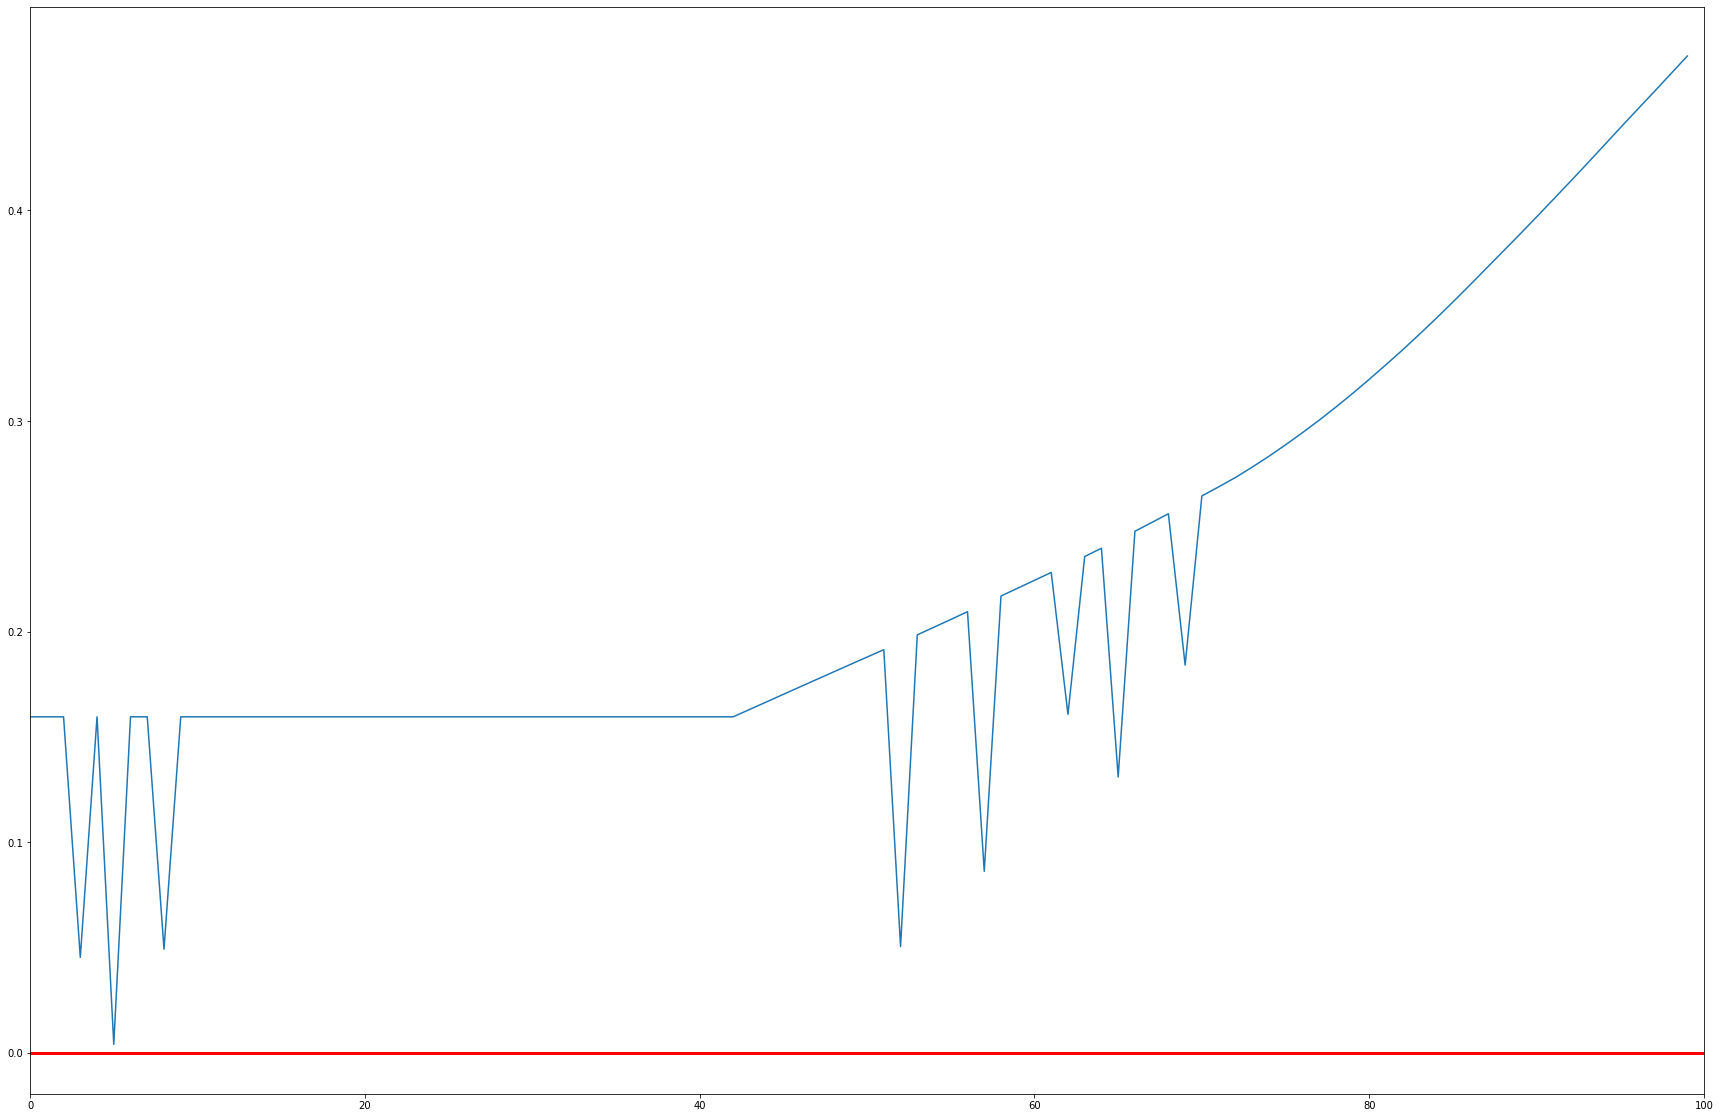

In [28]:
my_agent = DeepQAgent_Improved(env.action_space, mode="DDQN")
trainer = TrainAgent(agent=my_agent, env=env)
trainer.train(nb_frame)

plt.figure(figsize=(30,20))
plt.plot(my_agent.deep_q.qvalue_evolution)
plt.axhline(y=0, linewidth=3, color='red')
_ = plt.xlim(0, len(my_agent.deep_q.qvalue_evolution))